In [11]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
# Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
# Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [12]:
%config Completer.use_jedi = False
from keras.applications.xception import Xception
from keras.preprocessing import image
conv_base = Xception(weights="imagenet",include_top=False,input_shape=(299,299,3))
conv_base.summary() # input 299,299,3
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(5, activation="softmax"))

model.summary()
conv_base.trainable = False
import os
import numpy as np
base_dir = '../../dataset_action/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')
# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        target_size=(299, 299),
        batch_size=20,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=20,
        class_mode='categorical')
model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=['acc'])


Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               52429056  
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total params: 73,291,821
Trainable params: 73,237,293
Non-trainable params: 54,528
_________________________________________________________________
Found 2112 images belonging to 5 classes.
Found 531 images belonging to 5 classes.


In [13]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [21]:

callbacks_list = [EarlyStopping(patience=3),ModelCheckpoint(filepath='./model.{epoch:02d}-{val_loss:.4f}.hdf5',monitor='val_loss',save_best_only=True)]
    
history = model.fit(
      train_generator,
      steps_per_epoch=2112//20,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=531//20,callbacks=callbacks_list)

Epoch 1/100
105/105 [==============================] - 71s 674ms/step - loss: 0.3375 - acc: 0.8939 - val_loss: 0.3760 - val_acc: 0.8519
Epoch 2/100
105/105 [==============================] - 72s 688ms/step - loss: 0.2864 - acc: 0.9049 - val_loss: 0.5077 - val_acc: 0.8708
Epoch 3/100
105/105 [==============================] - 71s 677ms/step - loss: 0.2408 - acc: 0.9288 - val_loss: 0.3504 - val_acc: 0.8454
Epoch 4/100
105/105 [==============================] - 71s 672ms/step - loss: 0.3127 - acc: 0.9011 - val_loss: 0.4139 - val_acc: 0.7613
Epoch 5/100
105/105 [==============================] - 74s 707ms/step - loss: 0.2927 - acc: 0.9044 - val_loss: 0.3935 - val_acc: 0.8376
Epoch 6/100
105/105 [==============================] - 75s 718ms/step - loss: 0.2159 - acc: 0.9283 - val_loss: 0.1296 - val_acc: 0.8630
Epoch 7/100
105/105 [==============================] - 73s 691ms/step - loss: 0.1684 - acc: 0.9393 - val_loss: 0.2516 - val_acc: 0.8376
Epoch 8/100
105/105 [===========================

In [6]:
model.save("activate_best.h5")

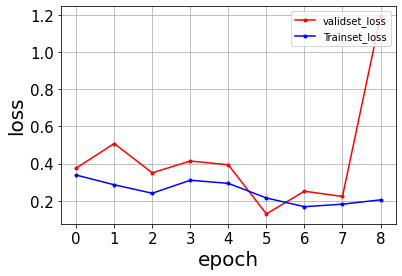

In [22]:

import matplotlib.pyplot as plt

import numpy as np
# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='validset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('epoch', fontsize = 20)
plt.ylabel('loss', fontsize = 20)
plt.savefig(".dog_action_best_loss.png", bbox_inches = 'tight')
plt.show()

In [8]:
import pickle 


In [9]:
f = open("dog_action_img_best.pkl","wb")
pickle.dump(history.history,f)
f.close()

In [19]:
history

{'val_loss': [0.791790246963501, 0.3402412235736847, 2.2725448608398438],
 'val_acc': [0.7480769157409668, 0.8023483157157898, 0.790606677532196],
 'loss': [3.346758872840418, 0.6429454014346317, 0.553885489342517],
 'acc': [0.7041109, 0.8183556, 0.84655833]}

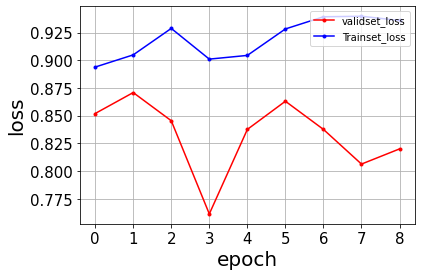

In [23]:

import matplotlib.pyplot as plt

import numpy as np
# 테스트 셋의 오차
y_vloss = history.history['val_acc']

# 학습셋의 오차
y_loss = history.history['acc']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='validset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xticks(fontsize = 15)
plt.yticks(fontsize =15)
plt.xlabel('epoch', fontsize = 20)
plt.ylabel('loss', fontsize = 20)
plt.savefig(".dog_action_best_acc.png", bbox_inches = "tight")
plt.show()

In [ ]:

import matplotlib.pyplot as plt

import numpy as np
# 테스트 셋의 오차
y_vloss = history['val_loss']

# 학습셋의 오차
y_loss = history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='validset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()